<a href="https://colab.research.google.com/github/VvS-2403/Svd-Applications/blob/main/AudioDenoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Converted trumpet.mp3 → trumpet.wav
Loaded: trumpet.wav | Sample rate: 16000 | Samples: 33024
Noisy audio saved: trumpet_noisy.wav

------ MATRIX SHAPES ------
U: (513, 66)
S: (66,)
Vᵀ: (66, 66)


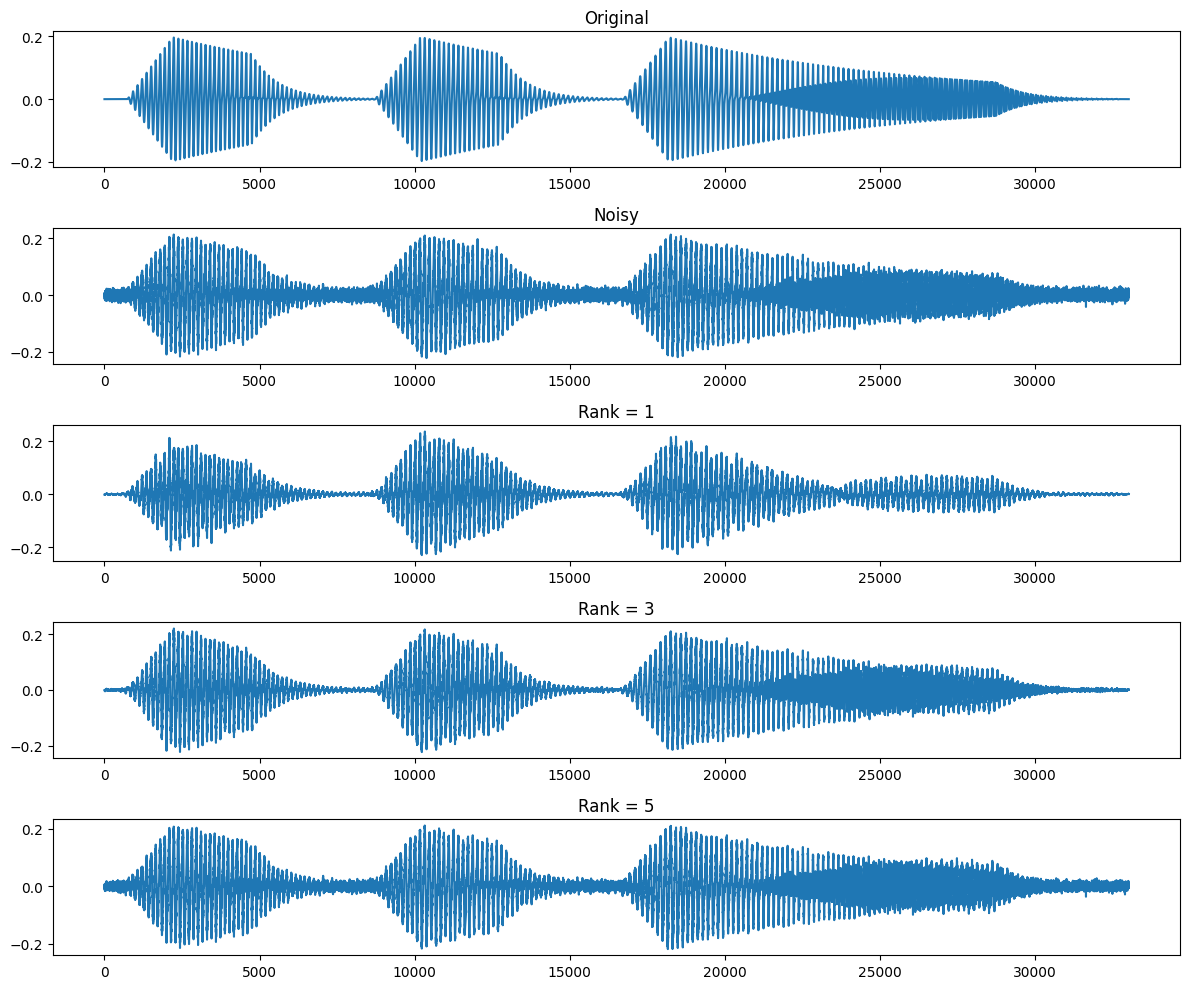

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment


# 1. USER INPUT FILE (MP3 → WAV)
INPUT_MP3 = "trumpet.mp3"
WAV_FILE = "trumpet.wav"
NOISY_FILE = "trumpet_noisy.wav"

DENOISED_R2 = "trumpet_rank1.wav"
DENOISED_R3 = "trumpet_rank3.wav"
DENOISED_R5 = "trumpet_rank5.wav"

audio = AudioSegment.from_file(INPUT_MP3)
audio = audio.set_channels(1).set_frame_rate(16000)
audio.export(WAV_FILE, format="wav")
print(f"Converted {INPUT_MP3} → {WAV_FILE}")



# 2. LOAD WAV + NORMALIZE
sr, y = wavfile.read(WAV_FILE)

if y.dtype == np.int16:
    y = y.astype(np.float32) / 32768.0
else:
    y = y.astype(np.float32)

print("Loaded:", WAV_FILE, "| Sample rate:", sr, "| Samples:", len(y))



# 3. ADD WHITE NOISE
noise = 0.01 * np.random.randn(len(y))
y_noisy = y + noise

wavfile.write(
    NOISY_FILE, sr,
    (np.clip(y_noisy, -1, 1) * 32767).astype(np.int16)
)
print("Noisy audio saved:", NOISY_FILE)



# 4. STFT → SVD ON MAGNITUDE
f, t, Zxx = signal.stft(y_noisy, fs=sr, nperseg=1024, noverlap=512)

mag = np.abs(Zxx)
phase = np.angle(Zxx)

U, S, Vt = np.linalg.svd(mag, full_matrices=False)

print("\n------ MATRIX SHAPES ------")
print("U:", U.shape)
print("S:", S.shape)
print("Vᵀ:", Vt.shape)



# 5. FUNCTION TO RECONSTRUCT USING ANY RANK
def reconstruct_rank(r):
    mag_r = (U[:, :r] * S[:r]) @ Vt[:r, :]
    Zxx_r = mag_r * np.exp(1j * phase)
    _, y_r = signal.istft(Zxx_r, fs=sr, nperseg=1024, noverlap=512)
    y_r = y_r[:len(y)]
    return y_r



# 6. RECONSTRUCT AUDIO AT RANKS 1, 3, 5
y_r2 = reconstruct_rank(1)
y_r3 = reconstruct_rank(3)
y_r5 = reconstruct_rank(5)

# Save audio
def save_audio(file, ysig):
    pcm = (np.clip(ysig, -1, 1) * 32767).astype(np.int16)
    wavfile.write(file, sr, pcm)

save_audio(DENOISED_R2, y_r2)
save_audio(DENOISED_R3, y_r3)
save_audio(DENOISED_R5, y_r5)



# 7. PLOT WAVEFORMS
plt.figure(figsize=(12, 10))

plt.subplot(511); plt.plot(y);      plt.title("Original");     plt.axis("tight")
plt.subplot(512); plt.plot(y_noisy);plt.title("Noisy");        plt.axis("tight")
plt.subplot(513); plt.plot(y_r2);   plt.title("Rank = 1");     plt.axis("tight")
plt.subplot(514); plt.plot(y_r3);   plt.title("Rank = 3");     plt.axis("tight")
plt.subplot(515); plt.plot(y_r5);   plt.title("Rank = 5");     plt.axis("tight")

plt.tight_layout()
plt.show()





